# This code follows the algorithm mentioned in the paper "[Forecasting Financial Crashes: Revisit to Log-Periodic Power Law](https://www.hindawi.com/journals/complexity/2018/4237471/)" by Bingcun Dai, Fan Zhang, Domenico Tarzia and Kwangwon Ahn


In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
%matplotlib inline

### LPPL Function

In [3]:
def LPPL(t, A, B, tc, m, C, omega, phi):
    return A + B*((tc-t)**m)*(1 + C*(np.cos(omega * np.log(tc-t) + phi)))

### Objective Function

In [4]:
def error_function(x):
    actual = np.log(y_train)
    pred = LPPL(X_train, x[0], x[1], x[2], x[3], x[4], x[5], x[6])
    return math.sqrt(mean_squared_error(actual,pred))

### [Peak Finding algorithm](https://github.com/TorLab/Peaks-Detection/blob/master/peaks_detection.ipynb)

In [5]:
def peak_finding(data,window_size):
    data_extended = np.concatenate([np.zeros(window_size),data,np.zeros(window_size)])
    max_list = []
        
    for i,value in enumerate(data_extended):
        if (i >= window_size) and (i < len(data_extended)-window_size):
            try:
                max_left = data_extended[(i-window_size):i+1].max()
                max_right = data_extended[i:(i+window_size)+1].max()
                chek_value = data_extended[i] - ((max_left+max_right)/2)
            except ValueError:
                 pass
                
            if (chek_value >=0):
                max_list.append((i-window_size,data[(i-window_size)]))
    return max_list

### [Grey Wolf Optimizer](https://github.com/7ossam81/EvoloPy/blob/master/optimizers/GWO.py)

In [6]:
def GWO(objf,lb,ub,dim,SearchAgents_no,Max_iter):
    
    # initialize alpha, beta, and delta_pos            
    Alpha_pos = np.zeros(dim)
    Alpha_score = float("inf")

    Beta_pos = np.zeros(dim)
    Beta_score = float("inf")
    
    Delta_pos=np.zeros(dim)
    Delta_score=float("inf")

    #Initialize the positions of search agents
    Positions = np.zeros((SearchAgents_no, dim))
    
    for i in range(dim):
        Positions[:,i] = (np.random.uniform(0,1, SearchAgents_no) * (ub[i] - lb[i]) + lb[i])
        
    Convergence_curve=np.zeros(Max_iter)
    
    # Main loop
    for l in range(0,Max_iter):
        for i in range(0,SearchAgents_no):
            
            # Return back the search agents that go beyond the boundaries of the search space
            for j in range(dim):
                Positions[i,j]=np.clip(Positions[i,j], lb[j], ub[j])
            
#             print(Positions[i,:])
            
            # Calculate objective function for each search agent
            fitness=objf(Positions[i,:])
            #print(fitness)
            # Update Alpha, Beta, and Delta
            if fitness<Alpha_score :
                Delta_score=Beta_score  # Update delta
                Delta_pos=Beta_pos.copy()
                Beta_score=Alpha_score  # Update beta
                Beta_pos=Alpha_pos.copy()
                Alpha_score=fitness; # Update alpha
                Alpha_pos=Positions[i,:].copy()
            
            
            if (fitness>Alpha_score and fitness<Beta_score ):
                Delta_score=Beta_score  # Update delta
                Delta_pos=Beta_pos.copy()
                Beta_score=fitness  # Update beta
                Beta_pos=Positions[i,:].copy()
            
            
            if (fitness>Alpha_score and fitness>Beta_score and fitness<Delta_score):                 
                Delta_score=fitness # Update delta
                Delta_pos=Positions[i,:].copy()

        a=2-l*((2)/Max_iter); # a decreases linearly fron 2 to 0
        
        # Update the Position of search agents including omegas
        for i in range(0,SearchAgents_no):
            for j in range (0,dim):     
                           
                r1=random.random() # r1 is a random number in [0,1]
                r2=random.random() # r2 is a random number in [0,1]
                
                A1=2*a*r1-a; # Equation (3.3)
                C1=2*r2; # Equation (3.4)
                
                D_alpha=abs(C1*Alpha_pos[j]-Positions[i,j]); # Equation (3.5)-part 1
                X1=Alpha_pos[j]-A1*D_alpha; # Equation (3.6)-part 1
                           
                r1=random.random()
                r2=random.random()
                
                A2=2*a*r1-a; # Equation (3.3)
                C2=2*r2; # Equation (3.4)
                
                D_beta=abs(C2*Beta_pos[j]-Positions[i,j]); # Equation (3.5)-part 2
                X2=Beta_pos[j]-A2*D_beta; # Equation (3.6)-part 2       
                
                r1=random.random()
                r2=random.random() 
                
                A3=2*a*r1-a; # Equation (3.3)
                C3=2*r2; # Equation (3.4)
                
                D_delta=abs(C3*Delta_pos[j]-Positions[i,j]); # Equation (3.5)-part 3
                X3=Delta_pos[j]-A3*D_delta; # Equation (3.5)-part 3             
                
                Positions[i,j]=(X1+X2+X3)/3  # Equation (3.7)
        
        Convergence_curve[l]=Alpha_score;

        if (l%1==0):
          print("Iteration",str(l),", best fitness:",Alpha_score)

    return Alpha_pos,Alpha_score

### Getting initial values of the parameter of LPPL using the procedure mentioned in the paper

In [7]:
def initial_values(window_size):
    initial_lppl_param = []
    peaks = peak_finding(y_train, window_size)
    peaks_t = [ x+1 for x,y in peaks ]
    peaks_len = len(peaks)
    
    #here instead of taking the consecutive peak randomly, we're doing it serially
    
    for i in range(0, peaks_len-2):
        pi = peaks_t[i] #i
        pj = peaks_t[i+1] #j 
        pk = peaks_t[i+2] #k
        p = (pj-pi)/(pk-pj) #row
        if (p <= 1):
            continue;
        tc_initial = (p*pk - pj)/(p - 1)
        omega_initial = (2 * math.pi)/(np.log(p))
        if tc_initial <= pk or tc_initial <= X_train[len(X_train)-1]:
            continue;
        phi_initial = math.pi - omega_initial * np.log(tc_initial - pk)
        beta_initial = 1 
        C_initial = 0
        
        # predict the values of A and B using Linear Regression
        t_diff = tc_initial - X_train
        t_diff = t_diff.reshape(-1, 1)
        regressor = LinearRegression()
        regressor.fit(t_diff, y_train_log)
        A_initial = regressor.intercept_
        B_initial = regressor.coef_[0]
       
        print("A: ",A_initial," B: ",B_initial," tc: ",tc_initial," beta: ",beta_initial," C: ",C_initial,
              " mega: ",omega_initial," phi: ",phi_initial)
        initial_lppl_param.append([A_initial, B_initial, tc_initial, beta_initial, C_initial, omega_initial, phi_initial])
       
    return initial_lppl_param

### Optimizing the parameters for a series of windows sizes
The upper bounds of the parameters are taken with the help of the table given in the paper in page 4

In [8]:
def fit_lppl_gwo(initial_window_size):
    tc_rmse = []

    for window_size in range(initial_window_size, len(X_train), 2):
        dim = 7
        params = initial_values(window_size)
        min_rmse = float('inf')
        corresponding_tc = 0
        for i in range(0, len(params)):
            lb = params[0]
            ub = [0]*7
            ub[0] = 2 * abs(lb[0])    # A
            ub[1] = max(2 * abs(lb[1]), 2)    # B
            ub[2] = abs(lb[2]) + 300    # tc
            ub[3] = 2    # beta
            ub[4] = 1    # C
            ub[5] = 2 * abs(lb[5])    # omega
            ub[6] = 2*math.pi    # phi
        
            final_params, rmse = GWO(error_function, lb, ub, dim, 40, 100)
            tc_rmse.append([final_params[2], rmse])
    
    return tc_rmse

### Reading data

In [9]:
data = pd.read_csv("tata.csv")

X = data['t'].to_numpy()
y = data['Close'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
y_train_log = np.log(y_train)

### Plotting data

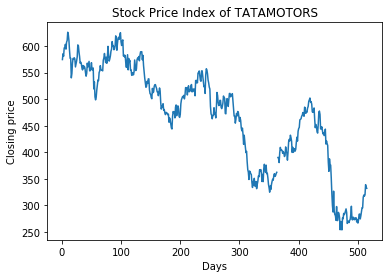

In [10]:
plt.plot(X,y)
plt.title("Stock Price Index of TATAMOTORS")
plt.xlabel("Days")
plt.ylabel("Closing price")
plt.show()

### Returns tc and RMSE for a series of windows sizes

In [11]:
result = fit_lppl_gwo(10)

A:  5.976927411889302  B:  0.0012872443926909146  tc:  366.0487804878049  beta:  1  C:  0  mega:  5.119812109129571  phi:  -6.856656084465175
Iteration 0 , best fitness: 297.8811675625651
Iteration 1 , best fitness: 4.326103089034843
Iteration 2 , best fitness: 0.2333817152868912
Iteration 3 , best fitness: 0.10900756567436405
Iteration 4 , best fitness: 0.08808827199182426
Iteration 5 , best fitness: 0.08808827199182426
Iteration 6 , best fitness: 0.08808827199182426
Iteration 7 , best fitness: 0.08584466524852816
Iteration 8 , best fitness: 0.08584466524852816
Iteration 9 , best fitness: 0.08233240683353145
Iteration 10 , best fitness: 0.08193438755317722
Iteration 11 , best fitness: 0.08193438755317722
Iteration 12 , best fitness: 0.08193438755317722
Iteration 13 , best fitness: 0.08193438755317722
Iteration 14 , best fitness: 0.08193438755317722
Iteration 15 , best fitness: 0.08193438755317722
Iteration 16 , best fitness: 0.08193438755317722
Iteration 17 , best fitness: 0.081934387

Iteration 64 , best fitness: 0.09101200011895258
Iteration 65 , best fitness: 0.09101200011895258
Iteration 66 , best fitness: 0.09101200011895258
Iteration 67 , best fitness: 0.09101200011895258
Iteration 68 , best fitness: 0.09101200011895258
Iteration 69 , best fitness: 0.09101200011895258
Iteration 70 , best fitness: 0.09101200011895258
Iteration 71 , best fitness: 0.09101200011895258
Iteration 72 , best fitness: 0.09101200011895258
Iteration 73 , best fitness: 0.09101200011895258
Iteration 74 , best fitness: 0.09101200011895258
Iteration 75 , best fitness: 0.09101200011895258
Iteration 76 , best fitness: 0.09101200011895258
Iteration 77 , best fitness: 0.09101200011895258
Iteration 78 , best fitness: 0.09101200011895258
Iteration 79 , best fitness: 0.09101200011895258
Iteration 80 , best fitness: 0.09101200011895258
Iteration 81 , best fitness: 0.09101200011895258
Iteration 82 , best fitness: 0.09101200011895258
Iteration 83 , best fitness: 0.09101200011895258
Iteration 84 , best 

Iteration 31 , best fitness: 0.0916321489425663
Iteration 32 , best fitness: 0.0916321489425663
Iteration 33 , best fitness: 0.0916321489425663
Iteration 34 , best fitness: 0.0916321489425663
Iteration 35 , best fitness: 0.0916321489425663
Iteration 36 , best fitness: 0.0916321489425663
Iteration 37 , best fitness: 0.09049558547964744
Iteration 38 , best fitness: 0.09049558547964744
Iteration 39 , best fitness: 0.09049558547964744
Iteration 40 , best fitness: 0.09049558547964744
Iteration 41 , best fitness: 0.09049558547964744
Iteration 42 , best fitness: 0.09049558547964744
Iteration 43 , best fitness: 0.09049558547964744
Iteration 44 , best fitness: 0.09049558547964744
Iteration 45 , best fitness: 0.09049558547964744
Iteration 46 , best fitness: 0.09049558547964744
Iteration 47 , best fitness: 0.09049558547964744
Iteration 48 , best fitness: 0.09049558547964744
Iteration 49 , best fitness: 0.09049558547964744
Iteration 50 , best fitness: 0.09049558547964744
Iteration 51 , best fitnes

Iteration 97 , best fitness: 0.08975970669221152
Iteration 98 , best fitness: 0.08975970669221152
Iteration 99 , best fitness: 0.08975970669221152


### The tc with the minimum RMSE is the crashing point

In [12]:
min_rmse = float('inf')
crashing = 0
for tc,rmse in result:
    print("Tc =",tc,"RMSE =",rmse)
    if rmse < min_rmse:
        min_rmse = rmse
        crashing = tc
print("Crashing Time = ",crashing,"days")

Tc = 366.0487804878049 RMSE = 0.0807319474112
Tc = 1215.0909090909092 RMSE = 0.09099994588452719
Tc = 1215.0909090909092 RMSE = 0.09026867348014654
Tc = 1215.0909090909092 RMSE = 0.09014192076094799
Tc = 1215.0909090909092 RMSE = 0.08975970669221152
Crashing Time =  366.0487804878049 days
